# Environment

In [479]:
import pandas as pd
import numpy as np
import requests as r
from datetime import datetime
from tqdm import tqdm
from time import sleep
import os
import plotly.express as px

In [ ]:
%%bash
pip install ../optionlib

In [ ]:
from optionlib import floating_quantile, menus, options
from optionlib.data import prices

# Query

## Instruments

In [54]:
# Query
currency = 'ETH'
kind = 'option'

url = f"https://history.deribit.com/api/v2/public/get_instruments?currency={currency}&kind={kind}&expired=true"
response = r.get(url)

tickers = response.json()

df_instruments = pd.DataFrame.from_dict(tickers['result'])

df_instruments.to_csv('instrument_list.csv')


In [45]:
# Load
df_instruments = pd.read_csv('instrument_list.csv')

df_instruments = df_instruments.set_index(
    'instrument_name'
).assign(
    has_more = False
)

df_instruments = df_instruments.assign(
    expiration = lambda x: pd.to_datetime(x.expiration_timestamp,unit='ms'),
    creation = lambda x: pd.to_datetime(x.creation_timestamp,unit='ms'),
    duration = lambda x: x.expiration - x.creation
)

## Trades

In [116]:
output_path='price_history/ETH_option_prices.csv'
interrupted_run = True
buffer = 0.1

cols = [
    'trade_seq', 
    'trade_id', 
    'timestamp', 
    'tick_direction', 
    'price',
    'mark_price', 
    'iv', 
    'instrument_name', 
    'index_price', 
    'direction',
    'amount', 
    'block_trade_id', 
    'liquidation'
]

if interrupted_run:
    trades = pd.read_csv(output_path)
    last_inst_idx = df_instruments.index.get_loc(trades.instrument_name.iloc[-1])
    query_list = df_instruments.iloc[last_inst_idx+1:].index
    del(trades)
else:
    query_list = df_instruments.index

for i in tqdm(query_list):
    url = f"https://history.deribit.com/api/v2/public/get_last_trades_by_instrument?count=10000&instrument_name={i}"
    response = r.get(url)

    df = pd.DataFrame.from_dict(
        response.json()['result']['trades']
    )
    
    col_dict = {i:'' for i in cols if i not in df.columns}

    df = df.assign(**col_dict)[cols]
    
    df.to_csv(
        output_path,
        mode='a',
        header=not os.path.exists(output_path)
    )
    
    df_instruments.loc[i,'has_more'] = response.json()['result']['has_more']
    
    sleep(buffer)

100%|██████████| 36693/36693 [6:09:49<00:00,  1.65it/s]   


## Delivery prices
Returns max of 100 items

In [617]:
offset=0
records_total = 10_000
responses = list()

while offset < records_total:
    url = f"https://www.deribit.com/api/v2/public/get_delivery_prices?count=100&index_name=eth_usd&offset={offset}"

    response = r.get(url)
    offset += 100
    records_total = response.json()['result']['records_total']
    responses += response.json()['result']['data']
    print(offset)
    sleep(1)
    
delivery_prices = pd.DataFrame.from_dict(responses)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [288]:
delivery_prices = pd.DataFrame.from_dict(responses).assign(
    expiration_date = lambda x: pd.to_datetime(x.date)
).set_index('expiration_date').drop(columns = 'date')

In [237]:
delivery_prices.reset_index().to_csv('price_history/eth_prices.csv')

## Price history

In [ ]:
inst = 'ETH_USDC'
start_ts = int(df_instruments.creation.min().timestamp()*1000)
end_ts = int(datetime.now().timestamp()*1000)
res = 1

interval = res*60*1000*5001
step_ts_start = end_ts - interval
step_ts_end = end_ts
output_path = 'price_history/eth_usdc_chart.csv'

cols = [
    'volume',
    'ticks',
    'status',
    'open',
    'low',
    'high',
    'cost',
    'close'
]

while step_ts_end > start_ts:
    print(pd.to_datetime(step_ts_start,unit = 'ms'))
    url = (
        f"https://history.deribit.com/api/v2/public/get_tradingview_chart_data?"
        + f"end_timestamp={step_ts_end}&instrument_name={inst}&resolution={res}&start_timestamp={step_ts_start}")
    response = r.get(url)
    df = pd.DataFrame.from_dict(response.json()['result'])[cols]

    df.to_csv(
        output_path,
        mode='a',
        header=not os.path.exists(output_path)
    )
    
    step_ts_start -= interval
    step_ts_end -= interval

# Clean

## Merge

In [264]:
path_trades = 'price_history/ETH_option_prices.csv'

data_trades = pd.read_csv(path_trades)

keep_cols = [
    'price',
    'mark_price',
    'iv',
    'instrument_name',
    'index_price',
    'amount',
    'direction',
    'timestamp'
]

data_trades = data_trades[keep_cols]

data_trades = data_trades.assign(
    timestamp = lambda x: pd.to_datetime(x.timestamp,unit = 'ms'),
    amount = lambda x: x.amount.astype(int)
)

data_trades.set_index(['instrument_name','timestamp'],inplace = True)

df_instruments_merge = df_instruments[[
    'strike',
    'option_type',
    'expiration',
    'creation',
    'duration'
]].assign(
    option_type = lambda x: x.option_type.str[0],
    strike = lambda x: x.strike.astype(int)
)

In [265]:
data_trades = data_trades.join(df_instruments_merge)

In [276]:
path_delivery = 'price_history/eth_prices.csv'
data_delivery = pd.read_csv(path_delivery)

data_delivery = data_delivery.assign(
    expiration_dt = lambda x: pd.to_datetime(x.date)
).set_index('expiration_dt')[['delivery_price']]



In [280]:
data_trades = data_trades.assign(
    expiration_dt = lambda x: pd.to_datetime(x.expiration.dt.date)
).set_index(
    'expiration_dt',
    append = True
).join(data_delivery)

In [281]:
data_trades.to_parquet('price_history/trade_data_cleaned.parquet')

## Collapse

In [417]:
data_trades = pd.read_parquet('price_history/trade_data_cleaned.parquet')

data_trades = data_trades.reset_index().assign(
    bucket = lambda x: x.timestamp.dt.ceil("H"),
    DTE = lambda x: x.expiration - x.bucket,
    strike_dist = lambda x: abs(x.strike - x.index_price),
    index_return = lambda x: (x.delivery_price/x.index_price) - 1,
    abs_index_return = lambda x: x.index_return.abs()
)

strike_dist_min_idx = data_trades.groupby(['bucket','DTE','option_type']).strike_dist.idxmin()

data_trades = data_trades.loc[strike_dist_min_idx]

In [411]:
data_trades.to_parquet('price_history/iv_by_dte.parquet')

In [445]:
dte = 1

temp = data_trades.loc[
    data_trades.DTE.between(pd.to_timedelta(dte,'d'),pd.to_timedelta(dte+1,'d'))
    & data_trades.option_type.eq('c')
]

/Users/dwynne891/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



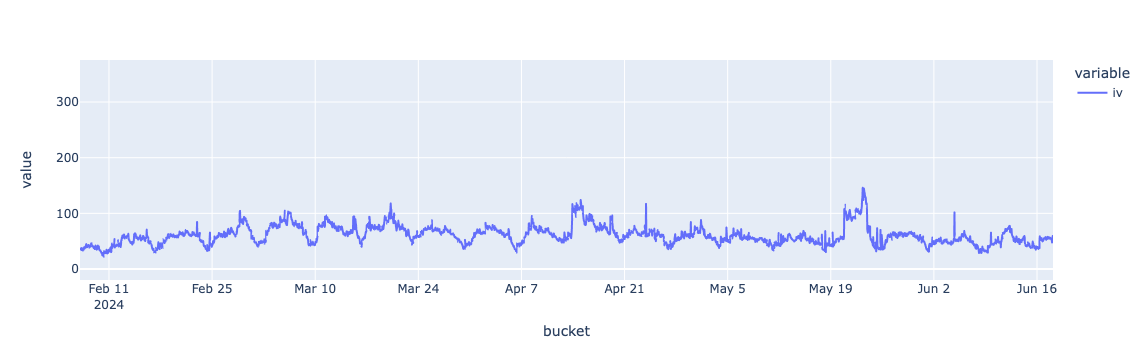

In [453]:
px.line(temp.set_index('bucket').sort_index().iv)

In [461]:
dte = 1

temp = data_trades.loc[
    data_trades.DTE.eq(pd.to_timedelta(7,unit='d'))
    & data_trades.option_type.eq('c')
]

/Users/dwynne891/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



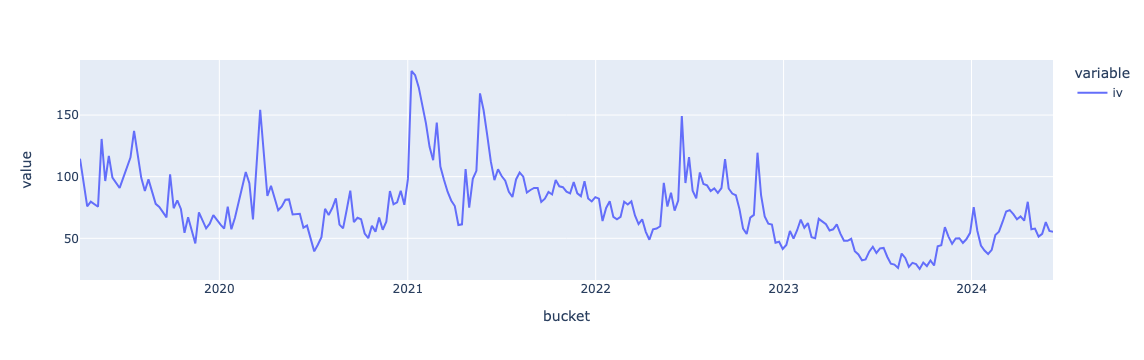

In [466]:
px.line(temp.set_index('bucket').sort_index().iv)

In [464]:
temp

,instrument_name,timestamp,expiration_dt,price,mark_price,iv,index_price,amount,direction,strike,option_type,expiration,creation,duration,delivery_price,bucket,DTE,strike_dist,index_return,abs_index_return
2619,ETH-12APR19-170-C,2019-04-05 07:50:32.436,2019-04-12,0.0470,0.039380,114.59,163.05,1,sell,170,c,2019-04-12 08:00:00,2019-03-29 08:01:00,13 days 23:59:00,163.80,2019-04-05 08:00:00,7 days,6.95,0.004600,0.004600
4679,ETH-26APR19-170-C,2019-04-19 07:57:07.548,2019-04-26,0.0500,0.046107,75.96,172.73,1,buy,170,c,2019-04-26 08:00:00,2019-04-12 08:03:58,13 days 23:56:02,152.01,2019-04-19 08:00:00,7 days,2.73,-0.119956,0.119956
5333,ETH-3MAY19-170-C,2019-04-26 07:11:49.976,2019-05-03,0.0100,0.008881,79.80,152.41,2,buy,170,c,2019-05-03 08:00:00,2019-04-19 08:01:00,13 days 23:59:00,160.62,2019-04-26 08:00:00,7 days,17.59,0.053868,0.053868
6803,ETH-17MAY19-180-C,2019-05-10 07:59:36.782,2019-05-17,0.0280,0.032088,75.56,174.28,1,sell,180,c,2019-05-17 08:00:00,2019-05-03 08:01:00,13 days 23:59:00,240.12,2019-05-10 08:00:00,7 days,5.72,0.377783,0.377783
9339,ETH-24MAY19-240-C,2019-05-17 07:02:43.890,2019-05-24,0.0700,0.068075,130.61,238.82,1,buy,240,c,2019-05-24 08:00:00,2019-05-11 08:24:00,12 days 23:36:00,247.46,2019-05-17 08:00:00,7 days,1.18,0.036178,0.036178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10031176,ETH-17MAY24-3050-C,2024-05-10 07:03:55.064,2024-05-17,0.0295,0.028691,51.34,3052.49,1,buy,3050,c,2024-05-17 08:00:00,2024-04-25 08:01:00,21 days 23:59:00,3024.53,2024-05-10 08:00:00,7 days,2.49,-0.009160,0.009160
10070374,ETH-24MAY24-2950-C,2024-05-17 07:04:05.699,2024-05-24,0.0330,0.032541,53.59,2967.02,15,buy,2950,c,2024-05-24 08:00:00,2024-05-02 08:01:00,21 days 23:59:00,3667.24,2024-05-17 08:00:00,7 days,17.02,0.236001,0.236001
10170197,ETH-31MAY24-3700-C,2024-05-24 07:29:01.006,2024-05-31,0.0345,0.034708,63.10,3688.91,2,buy,3700,c,2024-05-31 08:00:00,2024-02-22 08:01:00,98 days 23:59:00,3732.26,2024-05-24 08:00:00,7 days,11.09,0.011751,0.011751
10242766,ETH-7JUN24-3750-C,2024-05-31 07:39:55.260,2024-06-07,0.0295,0.029708,55.92,3733.94,20,sell,3750,c,2024-06-07 08:00:00,2024-05-21 00:36:00,17 days 07:24:00,3816.04,2024-05-31 08:00:00,7 days,16.06,0.021987,0.021987


# Analysis

In [482]:
data_iv = pd.read_parquet('price_history/iv_by_dte.parquet')

In [ ]:
iv_slice = data_iv.set_index(['bucket','instrument_name']).loc[
    '2022-06-23 08:00:00',
    ['DTE','iv']
].set_index('DTE')

In [611]:
td_idx = pd.timedelta_range(
    start = '1 day',
    end = '90 days',
    freq = 'h'
)

iv_sparse = pd.DataFrame(
    index = td_idx.rename('DTE'),
    data = iv_slice
).assign(
    iv_linear = lambda x: x.iv.interpolate(method = 'linear'),
    iv_quad = lambda x: x.iv.interpolate(method = 'quadratic'),
    iv_cube = lambda x: x.iv.interpolate(method = 'cubic'),
    iv_spline = lambda x: x.iv.interpolate(method = 'spline',order = 4),
    #iv_poly = lambda x: x.iv.interpolate(method = 'polynomial',order = 5),
)

In [613]:
iv_sparse.dropna()

,iv,iv_linear,iv_quad,iv_cube,iv_spline
DTE,,,,,
1 days,116.79,116.79,116.79,116.79,116.79
8 days,109.80,109.80,109.80,109.80,109.80
15 days,107.96,107.96,107.96,107.96,107.96
36 days,100.10,100.10,100.10,100.10,100.10
64 days,90.30,90.30,90.30,90.30,90.30


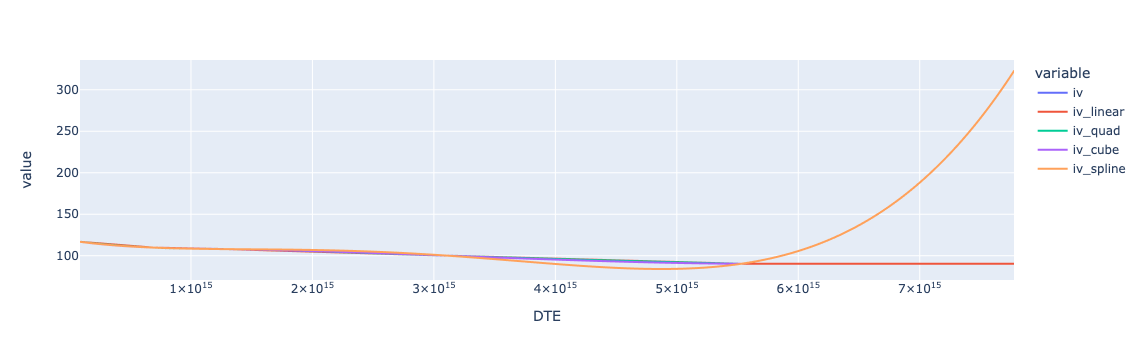

In [615]:
px.line(iv_sparse)

In [621]:
test = pd.read_csv('price_history/eth_usdc_chart.csv')

In [627]:
test.assign(
    ticks = lambda x: pd.to_datetime(x.ticks,unit = 'ms')
)

,Unnamed: 0,volume,ticks,status,open,low,high,cost,close
0,0,0.0001,2024-06-23 01:52:00,ok,3507.0,3507.0,3507.0,0.3507,3507.0
1,1,0.0000,2024-06-23 01:53:00,ok,3507.0,3507.0,3507.0,0.0000,3507.0
2,2,0.0000,2024-06-23 01:54:00,ok,3507.0,3507.0,3507.0,0.0000,3507.0
3,3,0.0000,2024-06-23 01:55:00,ok,3507.0,3507.0,3507.0,0.0000,3507.0
4,4,0.0000,2024-06-23 01:56:00,ok,3507.0,3507.0,3507.0,0.0000,3507.0
...,...,...,...,...,...,...,...,...,...
667774,2641,0.0000,2023-04-26 09:06:00,ok,1875.0,1875.0,1875.0,0.0000,1875.0
667775,2642,0.0000,2023-04-26 09:07:00,ok,1875.0,1875.0,1875.0,0.0000,1875.0
667776,2643,0.0000,2023-04-26 09:08:00,ok,1875.0,1875.0,1875.0,0.0000,1875.0
667777,2644,0.0000,2023-04-26 09:09:00,ok,1875.0,1875.0,1875.0,0.0000,1875.0
